In [1]:
import numpy as np
import numpy.ma as ma

import jax
import jax.numpy as jnp
from jax import random

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm

import plotly.graph_objs as go
import plotly.express as px 

from kernels import *
from utils import *



In [2]:

def DDM(mu, sigma, dt, total_time, key, trials):
    num_trajectories = len(mu)
    num_steps = int(total_time / dt)
    x = jnp.zeros((num_trajectories, num_steps + 1))
    ls_RT = []
    ls_acc = []

    keys = random.split(key, num_trajectories)

    for i in range(num_trajectories):
        current_key = keys[i]
        for t in range(num_steps): 
            if jnp.abs(x[i, t]) < 1:
                normal_sample = random.normal(current_key, shape=())
                x = x.at[i, t + 1].set(x[i, t] + mu[i] * dt + sigma * jnp.sqrt(dt) * normal_sample)
                current_key, subkey = random.split(current_key)
            else:
                ls_RT.append(t)
                ls_acc.append(1 if jnp.sign(x[i, t]) == jnp.sign(mu[i]) else -1)
                
                x = x.at[i, t:].set(jnp.sign(x[i, t]))
                break
    return x, ls_RT, ls_acc

mu = np.array([-0.64, -0.32, -0.16, -0.08, -0.04, 0.0, 0.04, 0.08, 0.16, 0.32, 0.64])  
sigma = 0.35
dt = 0.1
total_time = 100
trials = 150

ls_RTs = []
ls_accs = []
paths = jnp.zeros((trials, len(mu), int(total_time / dt) + 1))
for i in range(trials):
    key = random.PRNGKey(42 + i)
    path, ls_RT, ls_acc = DDM(mu, sigma, dt, total_time, key, trials) 
    paths = paths.at[i].set(path)
    ls_RTs.append(ls_RT)
    ls_accs.append(ls_acc)

accs = jnp.array(ls_accs)
RTs = jnp.array(ls_RTs)
paths = paths[:,:, :jnp.max(RTs)]
#paths_motion_on = paths[:,:, :jnp.min(RTs)]

# single_trial = False
# if single_trial:
#     paths_run = paths.reshape(-1, jnp.max(RTs))
# else:
#     paths_run = jnp.mean(paths, axis=0)#[jnp.newaxis,:,:]

In [16]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/DDM/paths', paths)

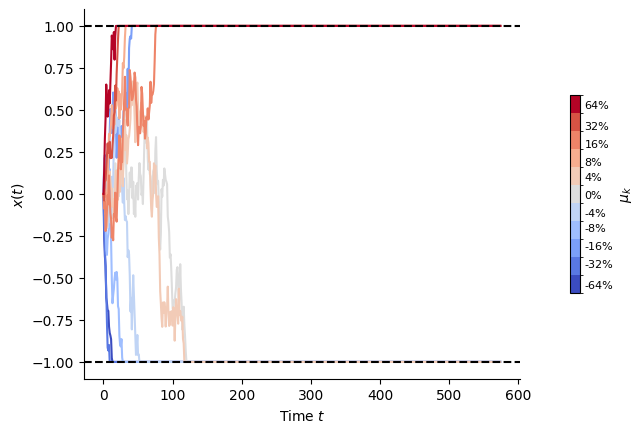

In [ ]:

fig, ax = plt.subplots()
#times = np.linspace(0, total_time, int(total_time / dt) + 1)

boundaries = np.concatenate(([mu[0] - (mu[1] - mu[0])/2], (mu[:-1] + mu[1:])/2, [mu[-1] + (mu[-1] - mu[-2])/2]))
norm = mcolors.BoundaryNorm(boundaries, ncolors=len(mu))
cmap = plt.get_cmap('coolwarm', len(mu))

for i, m in enumerate(mu):
    ax.plot(paths[3, i, :], color=cmap(norm(m)))

ax.axhline(y=1, color='black', linestyle='--')
ax.axhline(y=-1, color='black', linestyle='--')
ax.set_xlabel('Time $t$')
ax.set_ylabel(r'$x(t)$')


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
 
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.1, ticks=mu)
cbar.ax.tick_params(size=0) 
cbar.set_label('$\mu_k$')
cbar.set_ticklabels([f'{100*m:.0f}%' for m in mu], fontsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
def parametric_curve_v(x, mu):
    val = len(mu)//2
    x_1 = x[:,:val][:, ::-1]
    x_2 = x[:,val+1:]
    return x_1, x_2

RTs_1, RTs_2 = parametric_curve_v(RTs, mu)
accs_1, accs_2 = parametric_curve_v(accs, mu)

val = len(mu)//2
RTs_p = (RTs_1 + RTs_2) /2 
RTs_p = jnp.concatenate((RTs[:,val][:,jnp.newaxis], RTs_p), axis=1)

p_correct_1 = (jnp.sum(accs_1 == 1, axis=0) / accs_1.shape[0]) * 100
p_correct_2 = (jnp.sum(accs_2 == 1, axis=0) / accs_2.shape[0]) * 100
p_correct = (p_correct_1 + p_correct_2) /2 
p_correct = jnp.concatenate((jnp.array([50]), p_correct), axis=0)

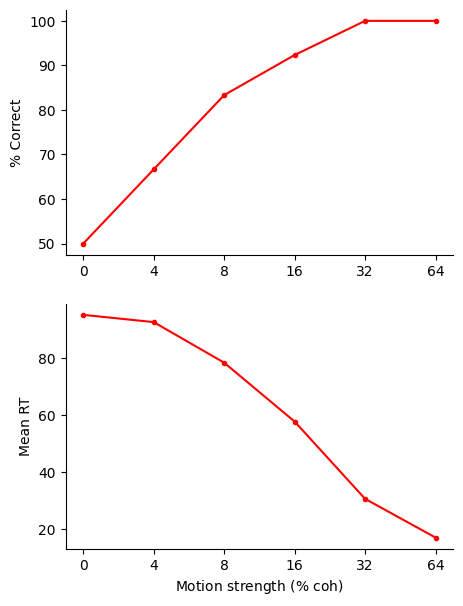

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(5,7))

axs[0].plot(p_correct, marker='.', color='r' )
axs[0].set_ylabel('% Correct')
axs[1].plot(jnp.mean(RTs_p, axis=0), marker='.', color='r')
axs[1].set_ylabel('Mean RT')
axs[1].set_xlabel('Motion strength ($\%$ coh)')
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ticks = np.arange(len(mu[val:]))  
    tick_labels = [f"{int(x * 100)}" for x in mu[val:]]  
    ax.set_xticks(ticks)  
    ax.set_xticklabels(tick_labels)  



In [97]:
def project(paths, key, proj_dims = 10):
    proj_matrix = random.normal(key, (proj_dims, 1))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                                        #(N',N)
    return jnp.einsum('dn,lknt->lkdt', proj_matrix, paths[:,:,:,:])           #(trial, K, N=1, T) #jnp.newaxis

def relu(x):
    return jnp.maximum(0, x)

def add_random_mode(X, key1, mean=0, std_dev=1):
    trials, K, T = X.shape    
    traj = random.normal(key1, (trials, K, T), dtype=X.dtype) * std_dev + mean
    X = jnp.stack((X, traj), axis=2)
    return X


def add_low_rank_noise(X, key1, key2, proj_dims = 2, sigma = 1 ):
    trials, K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    epsilon_t = random.normal(key2, (trials, K, T, proj_dims)) * sigma  
    noise = jnp.einsum('lktd,nd->lknt', epsilon_t, B)             
    
    X += noise                                                   
    return X


key = random.PRNGKey(0)
key1, key2, key3 = random.split(key, 3)

neural_traces = add_random_mode(paths, key1)

neural_traces = relu(project(neural_traces[:,:,:], key2))

neural_traces = neural_traces #* 5

#neural_traces = add_low_rank_noise(neural_traces, key2, key3)        #(trials, K, N, T)

X = jnp.mean( neural_traces, axis=0 )
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)               
A = A.reshape(N,-1)      

d = 3

In [ ]:

c = 40
kernel_function = K_X_Y_squared_exponential

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X, A, iterations=200, learning_rate=0.01, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

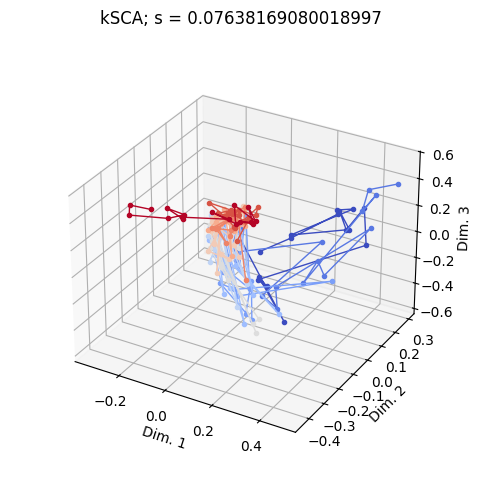

<Figure size 640x480 with 0 Axes>

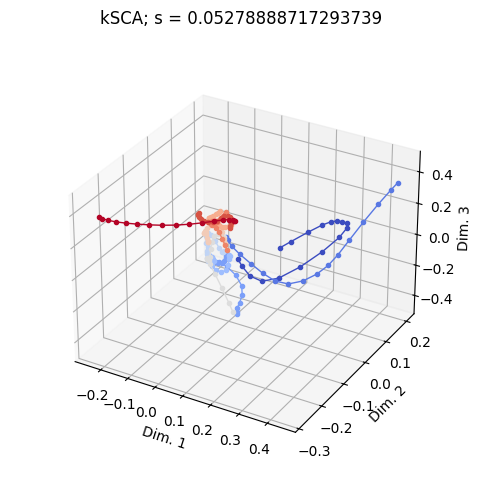

In [92]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u, _, _  = get_alpha(params, A, X, kernel_function, d)

X_reshaped = X.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

for i in range(Y.shape[0]):
    #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
    Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]

plot_3D_K_coded(Y, elevation=10, azimuth=60)

Y_smoothed = apply_gaussian_smoothing(Y, sigma=2)
plt.figure()
plot_3D_K_coded(Y_smoothed)

# plot_3D(Y[:,:,:])
# plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

In [93]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()

In [56]:
def analyse_projs(Y, RTs, ymin = -1, ymax=1):
    K, _, _ = Y.shape
    thresholds = jnp.floor(jnp.mean(RTs, axis=0)).astype(int)
    for i, idx in enumerate(thresholds):
        Y = Y.at[i, :, idx:].set(jnp.nan)


    plot_3D_K_coded(Y, rotate=True, azimuth=80, elevation=15)

    plt.figure()
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    cmap = plt.get_cmap('coolwarm', K)
    for k in range(Y.shape[0]):
        color = cmap(k / (K - 1)) 
        axs[0].plot(Y[k, 0, :], color=color)
        axs[1].plot(Y[k, 1, :], color=color)
        axs[2].plot(Y[k, 2, :], color=color)

    for ax in axs:
        ax.set_ylim(ymin, ymax)

Iteration 0, S: 242.4575958251953, S_ratio: 0.00029768707463517785
Iteration 10, S: 585.523193359375, S_ratio: 0.00021693593589589
Iteration 20, S: 1235.968017578125, S_ratio: 0.0002714460715651512
Iteration 30, S: 2480.947021484375, S_ratio: 0.0002712984278332442
Iteration 40, S: 5177.34375, S_ratio: 0.00034668779699131846
Iteration 50, S: 5930.1884765625, S_ratio: 0.0003791463386733085
Iteration 60, S: 8024.8828125, S_ratio: 0.0005223224870860577
Iteration 70, S: 9517.4658203125, S_ratio: 0.0006186868413351476
Iteration 80, S: 9495.3466796875, S_ratio: 0.000535478990059346
Iteration 90, S: 9904.947265625, S_ratio: 0.0005995686515234411
Iteration 100, S: 9264.3330078125, S_ratio: 0.0006288603763096035
Iteration 110, S: 9618.2265625, S_ratio: 0.0005960817215964198
Iteration 120, S: 9646.8994140625, S_ratio: 0.0005840060766786337
Iteration 130, S: 11085.4140625, S_ratio: 0.0006306160357780755
Iteration 140, S: 10834.7392578125, S_ratio: 0.0006411190261133015
Iteration 150, S: 9440.46093

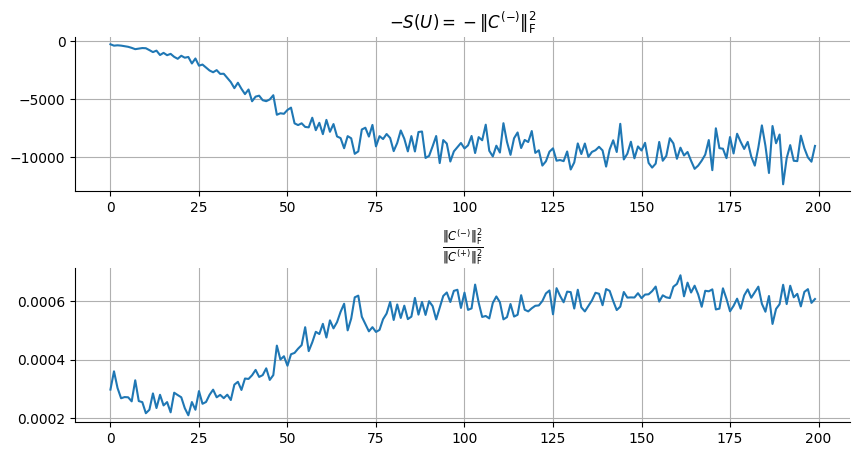

In [94]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X), d=d, learning_rate=0.01, iterations=200) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )



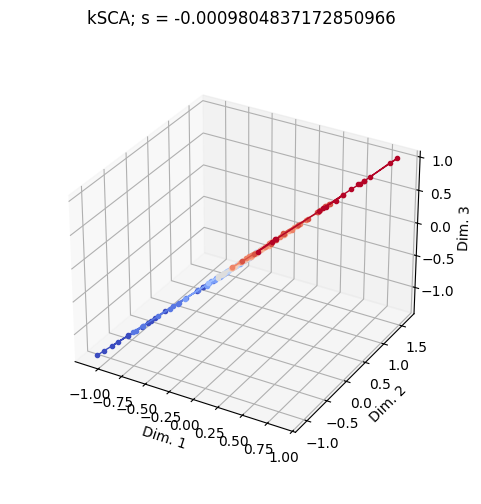

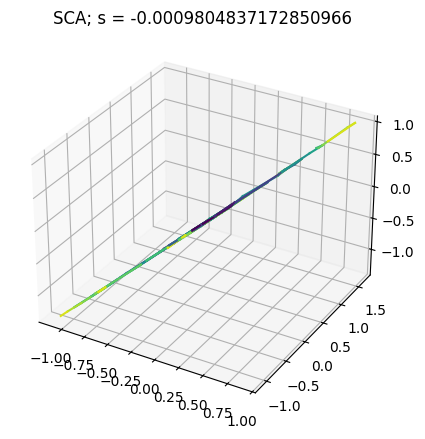

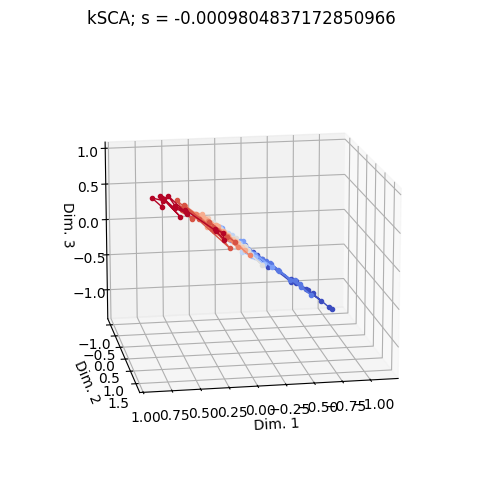

<Figure size 640x480 with 0 Axes>

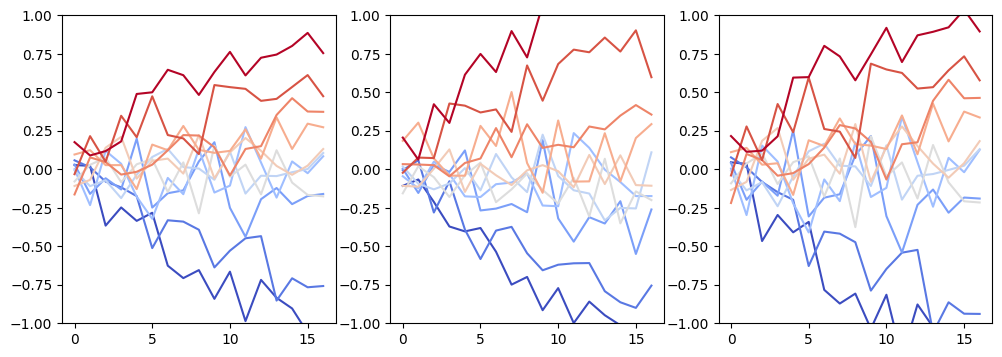

In [95]:
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X))


for i in range(Y.shape[0]):
    #Y = Y[:,:,:jnp.array(RTs).reshape(-1)[i]]
    Y = Y[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(Y)

plot_3D(Y[:,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

analyse_projs(Y, RTs)

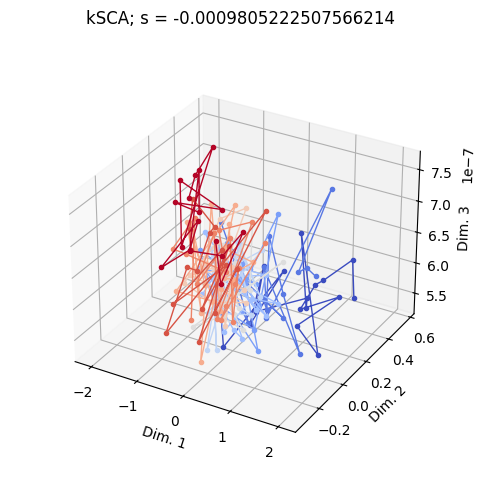

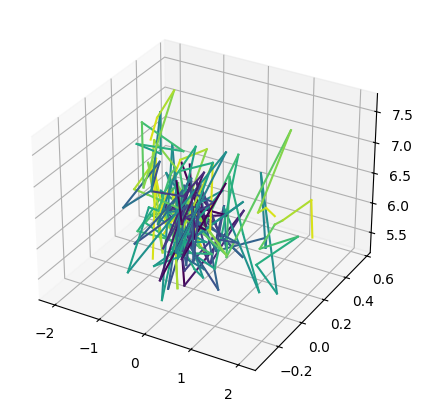

In [96]:
""" PCA """
Y_pca, PCs = get_pca(X, num_pcs=d)

for i in range(Y_pca.shape[0]):
    Y_pca = Y_pca[:,:,:int(jnp.mean(RTs, axis=0).squeeze()[i])]
    
plot_3D_K_coded(jnp.array(Y_pca))

plot_3D(Y_pca)

In [ ]:
fig = go.Figure()
num_time_points = Y.shape[-1]

color_scale = px.colors.diverging.RdBu 
for k in range(K):
    x = Y[k, 0, :]
    y = Y[k, 1, :]
    z = Y[k, 2, :]

    color_index = int(k / K * (len(color_scale) - 1))  # Scale the index to the length of the color scale

    fig.add_trace(go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='lines',
        line=dict(color=color_scale[color_index]),
        showlegend=False
    ))

fig.show()

ANALYSE RESULTS

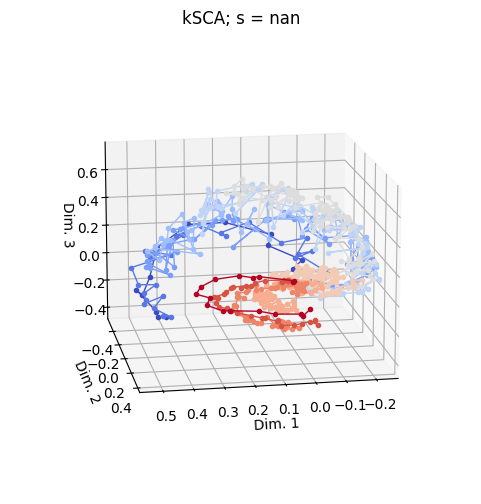

<Figure size 640x480 with 0 Axes>

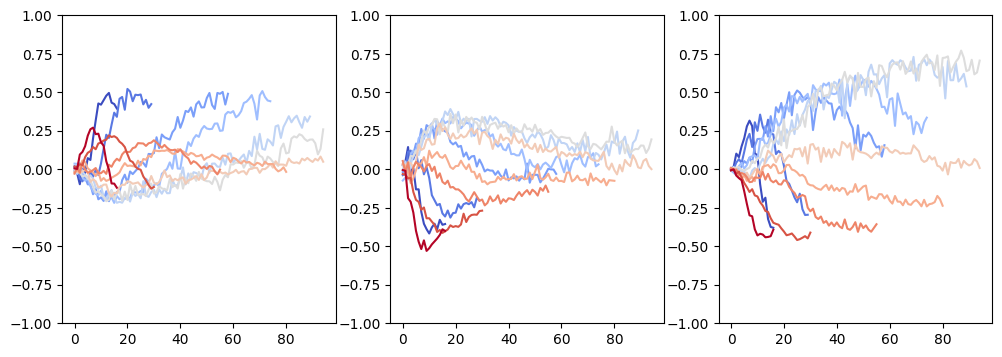

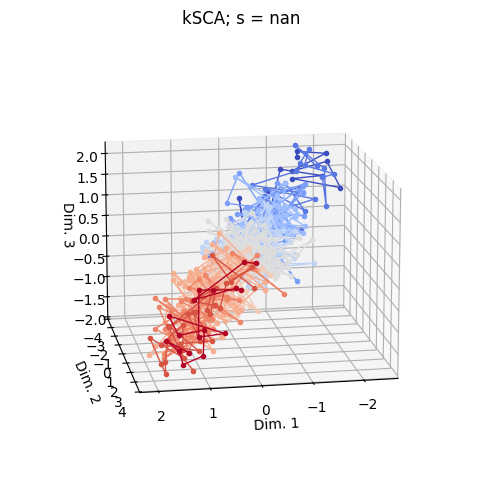

<Figure size 640x480 with 0 Axes>

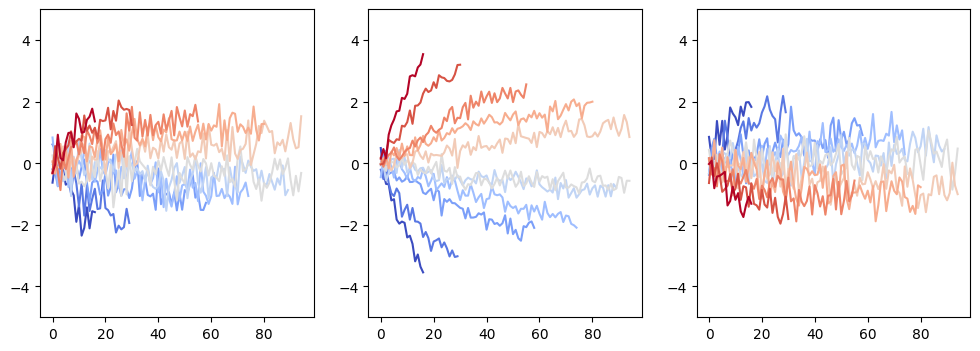

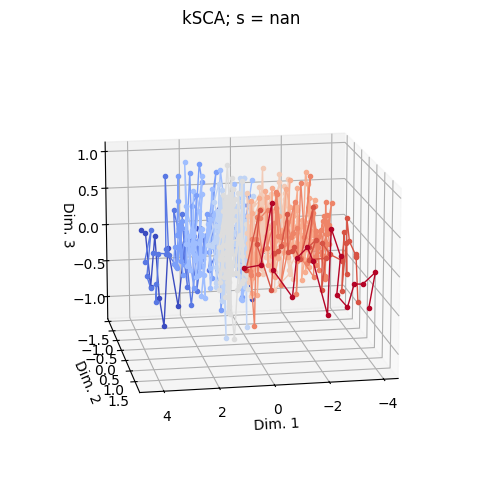

<Figure size 640x480 with 0 Axes>

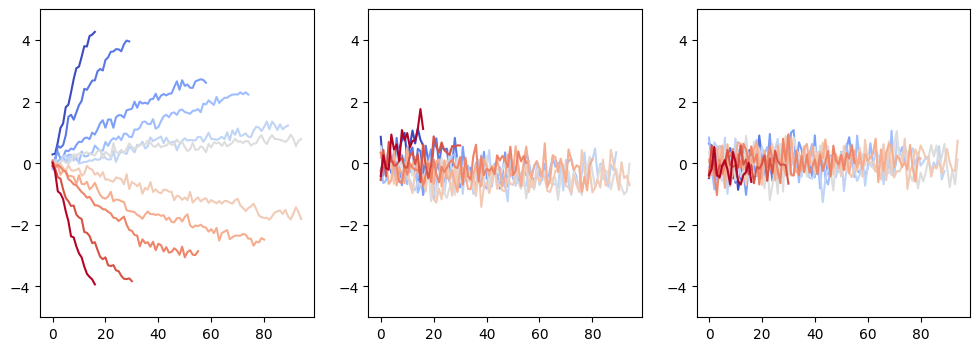

<Figure size 640x480 with 0 Axes>

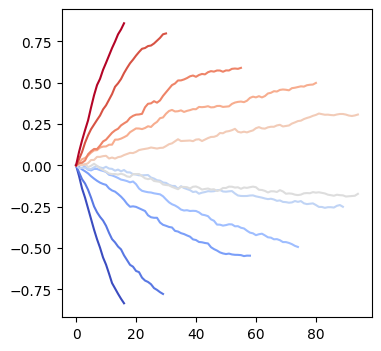

In [16]:
Y_kSCA = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/DDM/kSCA/Y_kSCA_3d_sigma5.0_proj_dims100.npy')
Y_SCA = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/DDM/SCA/Y_SCA_3d_sigma5.0_proj_dims100.npy')
Y_PCA = jnp.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/DDM/DDM/PCA/Y_PCA_3d_sigma5.0_proj_dims100.npy')

def analyse_projs(Y, RTs, ymin = -1, ymax=1):
    K, _, _ = Y.shape
    thresholds = jnp.floor(jnp.mean(RTs, axis=0)).astype(int)
    for i, idx in enumerate(thresholds):
        Y = Y.at[i, :, idx:].set(jnp.nan)


    plot_3D_K_coded(Y, rotate=True, azimuth=80, elevation=15)

    plt.figure()
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    cmap = plt.get_cmap('coolwarm', K)
    for k in range(Y.shape[0]):
        color = cmap(k / (K - 1)) 
        axs[0].plot(Y[k, 0, :], color=color)
        axs[1].plot(Y[k, 1, :], color=color)
        axs[2].plot(Y[k, 2, :], color=color)

    for ax in axs:
        ax.set_ylim(ymin, ymax)
analyse_projs(Y_kSCA, RTs)
analyse_projs(Y_SCA, RTs, ymin = -5, ymax=5)
analyse_projs(Y_PCA, RTs, ymin = -5, ymax=5)


plt.figure()
fig, ax = plt.subplots(figsize=(4,4))
cmap = plt.get_cmap('coolwarm', K)
paths_avg = jnp.mean(paths, axis=0)
thresholds = jnp.floor(jnp.mean(RTs, axis=0)).astype(int)
for i, idx in enumerate(thresholds):
    paths_avg = paths_avg.at[i, idx:].set(jnp.nan)

for k in range(paths_avg.shape[0]):
    color = cmap(k / (K - 1)) 
    ax.plot(paths_avg[k,:], color=color)       



In [27]:


A = jnp.mean(paths, axis=0).reshape(-1)[:,None]
B = Y_kSCA.swapaxes(1,2).reshape(-1, 3)
R2, _ = get_reg(B, A, B, A)

In [28]:
R2

0.5067188359682191